<a href="https://colab.research.google.com/github/caldi99/Computer-Vision-Project/blob/develop/TrainModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Create dataset folder
Paste hands2.csv

global()

dir()

del namevariable

In [1]:
!wget 'http://vision.soic.indiana.edu/egohands_files/egohands_data.zip'

--2022-06-03 20:41:31--  http://vision.soic.indiana.edu/egohands_files/egohands_data.zip
Resolving vision.soic.indiana.edu (vision.soic.indiana.edu)... 156.56.83.26
Connecting to vision.soic.indiana.edu (vision.soic.indiana.edu)|156.56.83.26|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1332784625 (1.2G) [application/zip]
Saving to: ‘egohands_data.zip.1’

egohands_data.zip.1 100%[===================>]   1.24G   102MB/s    in 9.2s    

2022-06-03 20:41:40 (139 MB/s) - ‘egohands_data.zip.1’ saved [1332784625/1332784625]



In [3]:
!unzip -qq "egohands_data.zip" -d "/content/dataset/" 

In [4]:
import os

#extension must be specified in .extension
def removeFiles(extension,initialPath):
  list = os.listdir(initialPath)
  for elem in list:
    if(len(elem.split(extension)) > 1):
      os.remove(initialPath + elem)

removeFiles(".m","/content/dataset/")
removeFiles(".mat","/content/dataset/")
removeFiles(".txt","/content/dataset/")

In [5]:
import os

def moveFiles(source,destination):
  list = os.listdir(source)
  i=0
  for dir in list:
    list2 = os.listdir(source + dir)
    for img in list2:
      if(len(img.split(".jpg")) > 1):
        os.replace(source + dir +"/"+img, destination + str(i)+".jpg")
      else:
        os.replace(source + dir +"/"+img, destination + img)

      i=i+1
      #os.replace("/content/dataset/images/" + dir +"/"+)

moveFiles("/content/dataset/_LABELLED_SAMPLES/","/content/dataset/")
removeFiles(".mat","/content/dataset/")

In [6]:
import os
def removeDirectories():
  list = os.listdir("/content/dataset/_LABELLED_SAMPLES")
  for dir in list:
    os.removedirs("/content/dataset/_LABELLED_SAMPLES/"+ dir)

removeDirectories()

# START "TRAINING"

In [7]:
#load images and name of the files
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
import os

BASE_DIR = "/content/dataset/"
list_files = os.listdir("/content/dataset/")
data = []
filenames = []


for file in list_files:
  imagePath = BASE_DIR + file
  image = load_img(imagePath, target_size=(224, 224))
  image = img_to_array(image)	
  data.append(image)
  filenames.append(file)

In [8]:
#load the targets

targets = []
CSV_PATH = "hands2.csv"
rows = open(CSV_PATH).read().strip().split("\n")

w = 1280
h = 720

for row in rows:
  row = row.split(",")

  (filename, startX1, startY1, endX1, endY1,startX2, startY2, endX2, endY2,startX3, startY3, endX3, endY3,startX4, startY4, endX4, endY4) = row 
   
  startX1 = float(startX1) / w
  startY1 = float(startY1) / h
  endX1 = float(endX1) / w
  endY1 = float(endY1) / h
  
  startX2 = float(startX2) / w
  startY2 = float(startY2) / h
  endX2 = float(endX2) / w
  endY2 = float(endY2) / h
  
  startX3 = float(startX3) / w
  startY3 = float(startY3) / h
  endX3 = float(endX3) / w
  endY3 = float(endY3) / h
  
  startX4 = float(startX4) / w
  startY4 = float(startY4) / h
  endX4 = float(endX4) / w
  endY4 = float(endY4) / h

  targets.append((startX1, startY1, endX1, endY1,startX2, startY2, endX2, endY2,startX3, startY3, endX3, endY3,startX4, startY4, endX4, endY4))

In [9]:
#prepare training set
import numpy as np
data = np.array(data,dtype ="float32") / 255.0
targets = np.array(targets,dtype ="float32")

In [10]:
#split the data
from sklearn.model_selection import train_test_split

split = train_test_split(data, targets, filenames, test_size=0.30, random_state=42)

(trainImages, testImages) = split[:2]
(trainTargets, testTargets) = split[2:4]
(trainFilenames, testFilenames) = split[4:]

del targets
del data
del filenames

In [14]:
#build the model
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.regularizers import l2

LEARNING_RATE = 1e-4

vgg = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
vgg.trainable = False

flatten = vgg.output
flatten = Flatten()(flatten)
bboxHead = Dense(128, activation="relu",kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(flatten)
bboxHead = Dense(64, activation="relu",kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(bboxHead)
bboxHead = Dense(32, activation="relu",kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(bboxHead)
bboxHead = Dense(16, activation="sigmoid")(bboxHead)
model = Model(inputs=vgg.input, outputs=bboxHead)

opt = Adam(learning_rate = LEARNING_RATE)
model.compile(loss="mse", optimizer=opt)
print(model.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [15]:
#train the model
EPOCHS = 10
BATCH_SIZE = 32

H = model.fit(trainImages, trainTargets, validation_data=(testImages, testTargets),
              batch_size = BATCH_SIZE,epochs = EPOCHS,
              verbose=1)

Epoch 1/10
105/105 [==============================] - 29s 267ms/step - loss: 2.3531 - val_loss: 1.4536
Epoch 2/10
105/105 [==============================] - 27s 260ms/step - loss: 1.1977 - val_loss: 1.0373
Epoch 3/10
105/105 [==============================] - 24s 225ms/step - loss: 0.9534 - val_loss: 0.8788
Epoch 4/10
105/105 [==============================] - 24s 225ms/step - loss: 0.8167 - val_loss: 0.7567
Epoch 5/10
105/105 [==============================] - 24s 227ms/step - loss: 0.7048 - val_loss: 0.6541
Epoch 6/10
105/105 [==============================] - 27s 258ms/step - loss: 0.6091 - val_loss: 0.5653
Epoch 7/10
105/105 [==============================] - 27s 257ms/step - loss: 0.5272 - val_loss: 0.4896
Epoch 8/10
105/105 [==============================] - 24s 229ms/step - loss: 0.4571 - val_loss: 0.4248
Epoch 9/10
105/105 [==============================] - 27s 258ms/step - loss: 0.3971 - val_loss: 0.3693
Epoch 10/10
105/105 [==============================] - 27s 257ms/step - l

In [12]:
#save the model
import shutil

MODEL_PATH = "model"
model.save(MODEL_PATH, save_format="h5")


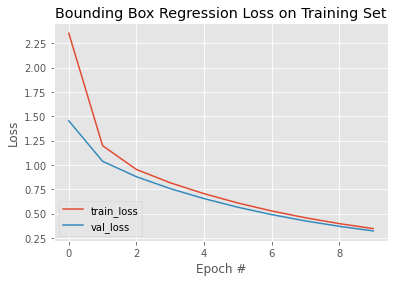

In [16]:
# plot the model training history
import matplotlib.pyplot as plt

N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.title("Bounding Box Regression Loss on Training Set")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")

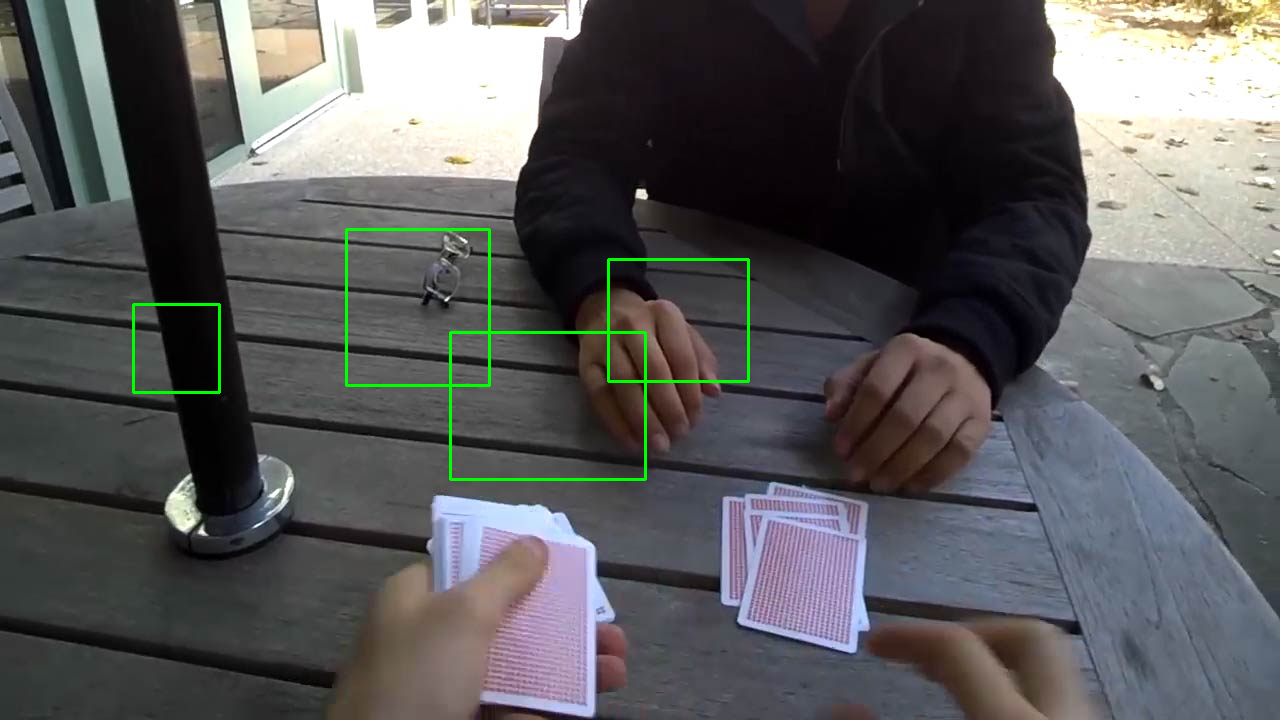

In [18]:
#predict
import cv2
import imutils
from google.colab.patches import cv2_imshow

image = load_img("/content/frame_1523.jpg", target_size=(224, 224))
image = img_to_array(image) / 255.0
image = np.expand_dims(image, axis=0)

preds = model.predict(image)[0]


(startX1, startY1, endX1, endY1,startX2, startY2, endX2, endY2,startX3, startY3, endX3, endY3,startX4, startY4, endX4, endY4) = preds






image = cv2.imread("/content/frame_1523.jpg")


w= 1280
h= 720

startX1 = int(startX1 * w)
startY1 = int(startY1 * h)
endX1 = int(endX1 * w)
endY1 = int(endY1 * h)

startX2 = int(startX2 * w)
startY2 = int(startY2 * h)
endX2 = int(endX2 * w)
endY2 = int(endY2 * h)

startX3 = int(startX3 * w)
startY3 = int(startY3 * h)
endX3 = int(endX3 * w)
endY3 = int(endY3 * h)

startX4 = int(startX4 * w)
startY4 = int(startY4 * h)
endX4 = int(endX4 * w)
endY4 = int(endY4 * h)
# draw the predicted bounding box on the image
cv2.rectangle(image, (startX1, startY1), (endX1, endY1),(0, 255, 0), 2)
cv2.rectangle(image, (startX2, startY2), (endX2, endY2),(0, 255, 0), 2)
cv2.rectangle(image, (startX3, startY3), (endX3, endY3),(0, 255, 0), 2)
cv2.rectangle(image, (startX4, startY4), (endX4, endY4),(0, 255, 0), 2)

cv2_imshow(image)